This notebook using CelebFaces Attributes (CelebA) Dataset for Face Generator by Deep Convolutional GANS

## Importing the libraries

In [7]:
import torch
import torchvision
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder
from torchinfo import summary
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from torchvision.utils import make_grid
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Creating DCGAN Architecture
Discriminator

In [8]:
class Discriminator(nn.Module):
    def __init__(self,image_channels, dicriminator_features):
        super(Discriminator, self).__init__()
    
    
        self.disc = nn.Sequential(

            # INPUT SIZE : 64*64
            # initial Layer not Batch Norm
            nn.Conv2d( image_channels, discriminator_features, kernel_size=4, stride=2, padding=1 ),
            nn.LeakyReLU(0.2),

            # Size : 32*32
            # batch Norm convolution Layers
            self._block( discriminator_features, discriminator_features*2 , 4 ,2 ,1 ),

            # Size: 16*16
            self._block( discriminator_features*2, discriminator_features*4 , 4 ,2 ,1 ),

             # Size: 8*8
            self._block( discriminator_features*4, discriminator_features*8 , 4 ,2 ,1 ),

            # final Layer
            nn.Conv2d(discriminator_features*8, 1 , 4, 2, 0),
            # Output Size : 1*1
            nn.Sigmoid()

        )
    
     # return a convulational block with batchNorm and leak reLU activation
    def _block(self, in_channels,out_channels, kernel_size, stride, padding , bias=False):

        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=bias
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
    )
        
    def forward(self,x):
        return self.disc(x)

In [9]:
# Generator 

class Generator(nn.Module):
    def __init__(self, z_dim, image_channels, generator_features):
        super(Generator, self).__init__()

        # Define the generator layers as an nn.Sequential
        self.gen = nn.Sequential(
            self._block(z_dim, generator_features * 16, 4, 1, 0),
            self._block(generator_features * 16, generator_features * 8, 4, 2, 1),
            self._block(generator_features * 8, generator_features * 4, 4, 2, 1),
            self._block(generator_features * 4, generator_features * 2, 4, 2, 1),
            nn.ConvTranspose2d(in_channels=generator_features * 2, out_channels=image_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding, bias=False):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=bias
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        return self.gen(x)

Weights intitializer

In [10]:
def initialize_weights(model):
    for module in model.modules():
        if isinstance(module, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d )):
            nn.init.normal_(module.weight.data,0,0.02)

Hyper Parameters

In [11]:
learning_rate = 2e-4
batch_size = 128
image_size = 64
image_channels = 3
z_dim = 100
num_epochs = 15
generator_features = 64
discriminator_features = 64

## Creating Data Loaders and Datasets

In [12]:
image_transforms = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

dataset = ImageFolder(root='/kaggle/input/celeba-dataset/img_align_celeba', transform=image_transforms)
data_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True )

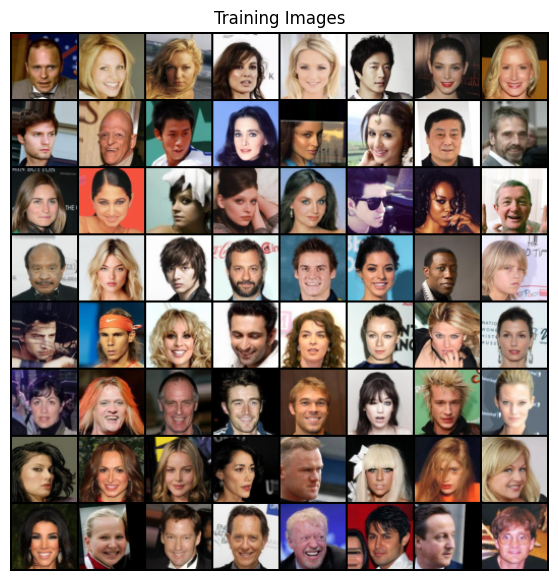

In [13]:
real_batch = next(iter(data_loader))
plt.figure(figsize=(7,7))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

Create Model Instances

In [14]:
generator = Generator(z_dim,image_channels,generator_features).to(device)
discriminator = Discriminator(image_channels,discriminator_features).to(device)

# initialize weights
initialize_weights(generator)
initialize_weights(discriminator)

Optimizers , Loss & Noise

In [15]:
optimizer_generator = optim.Adam(params=generator.parameters(), lr=learning_rate , betas=(0.5,0.999) )
optimizer_discriminator = optim.Adam(params=discriminator.parameters(), lr=learning_rate , betas=(0.5,0.999) )
criterion = nn.BCELoss()
fixed_noise = torch.randn(32, z_dim, 1, 1).to(device)


## Training DCGAN

In [16]:
generator.train()
discriminator.train()

for epoch in range(num_epochs):
    for batch_idx, (real_images, _) in enumerate(data_loader):
        real_images = real_images.to(device)
        
        ### Create noise tensor
        latent = torch.randn((batch_size, z_dim, 1, 1)).to(device)
        fake_images = generator(latent)

        ## Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        disc_real = discriminator(real_images).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = discriminator(fake_images.detach()).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake)/2
        
        optimizer_discriminator.zero_grad()
        loss_disc.backward()
        optimizer_discriminator.step()
        
        ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        output = discriminator(fake_images).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        
        optimizer_generator.zero_grad()
        loss_gen.backward()
        optimizer_generator.step()
        
        ### Print losses occasionally and show fake images
        if batch_idx % 50 == 0:
            print(
                f"Epoch [{epoch}/{num_epochs}] Batch {batch_idx}/{len(data_loader)} \
                Loss D: {loss_disc:.4f}, loss G: {loss_gen:.4f}"
            )


Epoch [0/15] Batch 0/1583                 Loss D: 0.6939, loss G: 0.7973
Epoch [0/15] Batch 50/1583                 Loss D: 0.0518, loss G: 2.9398
Epoch [0/15] Batch 100/1583                 Loss D: 0.0650, loss G: 3.5257
Epoch [0/15] Batch 150/1583                 Loss D: 0.2030, loss G: 3.2209
Epoch [0/15] Batch 200/1583                 Loss D: 0.5441, loss G: 1.6067
Epoch [0/15] Batch 250/1583                 Loss D: 0.4212, loss G: 1.7458
Epoch [0/15] Batch 300/1583                 Loss D: 0.3681, loss G: 2.3012
Epoch [0/15] Batch 350/1583                 Loss D: 0.8000, loss G: 1.6437
Epoch [0/15] Batch 400/1583                 Loss D: 0.5100, loss G: 1.9251
Epoch [0/15] Batch 450/1583                 Loss D: 0.5037, loss G: 2.1119
Epoch [0/15] Batch 500/1583                 Loss D: 0.5059, loss G: 1.5096
Epoch [0/15] Batch 550/1583                 Loss D: 0.4426, loss G: 1.7338
Epoch [0/15] Batch 600/1583                 Loss D: 0.5648, loss G: 1.5878
Epoch [0/15] Batch 650/1583 

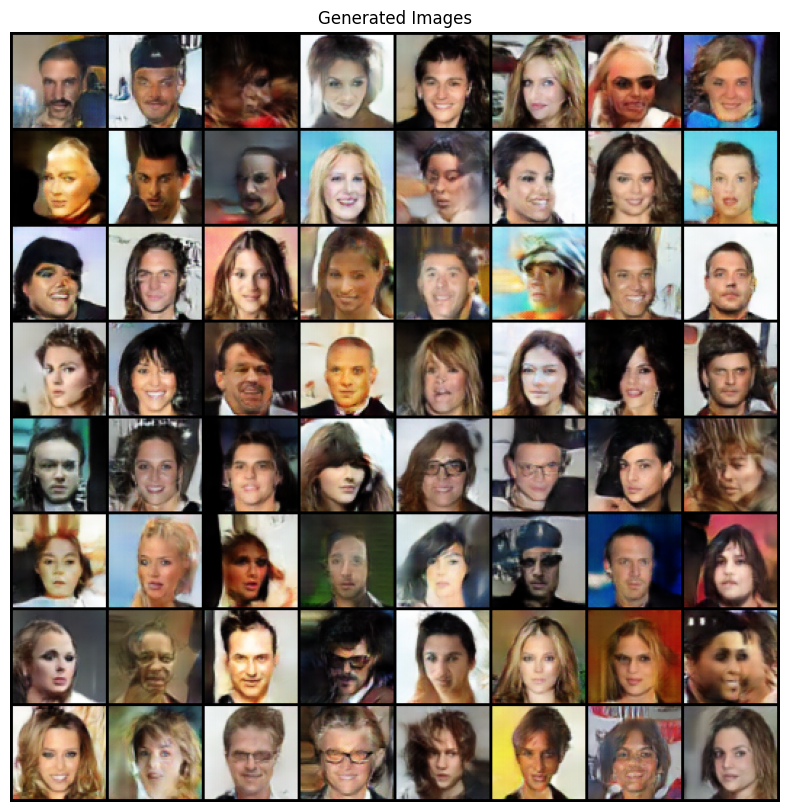

Generated images saved as 'generated_images.png'


In [19]:
# At the end of your script, add the following code:

# Set the generator to evaluation mode
generator.eval()

# Number of images to generate
num_images = 64

# Generate random noise
z = torch.randn(num_images, z_dim, 1, 1).to(device)
# Generate fake images
with torch.no_grad():
    fake_images = generator(z)

# Create a grid of images using make_grid with normalize=True
img_grid = make_grid(fake_images.cpu(), nrow=8, padding=2, normalize=True)

# Convert to numpy array and transpose dimensions for plotting
img_grid_np = img_grid.permute(1, 2, 0).numpy()

# Plot the grid of generated images
plt.figure(figsize=(10, 10))
plt.imshow(img_grid_np)
plt.axis('off')
plt.title("Generated Images")
plt.show()

# Optionally, save the generated images
torchvision.utils.save_image(fake_images, "generated_images.png", nrow=8, normalize=True)
print("Generated images saved as 'generated_images.png'")

In [25]:

save_path = "/kaggle/working/model_parameters.pth"

# Save the model state_dicts and optimizer state_dicts
torch.save({
    'generator_state_dict': generator.state_dict(),
    'discriminator_state_dict': discriminator.state_dict(),
    'optimizer_generator_state_dict': optimizer_generator.state_dict(),
    'optimizer_discriminator_state_dict': optimizer_discriminator.state_dict()
}, save_path)

print(f"Model saved to {save_path}")



Model saved to /kaggle/working/model_parameters.pth
